# <b>Theoreticl Questions<b>

**Q1:**
<br>
To evaluate how well our model performs at T1D classification, we need to have evaluation metrics that measures of its performances/accuracy. Which evaluation metric is more important to us: model accuracy or model performance? Give a simple example that illustrates your claim

**A1:**
<br>
The model performance would be a better evaluation metric in this case. Model accuracy is just the number of correct predictions made by the model devided by the total number of predictions - which would not be a good model in this case because we have a relatively small number of people in the population with the T1D. For example, if we use a classifier that classifies all patients as being healthy, we would get an accuracy of at least 99.67% (according to the assignment that states that up to 0.33% suffer from T1D), which is a very high accuracy, but this is a terrible classifier.

**Q2:**
<br>
T1D is often associated with other comorbidities such as a heart attack. You are asked to design a ML algorithm to predict which patients are going to suffer a heart attack. Relevant patient features for the algorithm may include blood pressure (BP), body-mass index (BMI), age (A), level of physical activity (P), and income (I). You should choose between two classifiers: the first uses only BP and BMI features and the other one uses all of the features available to you. Explain the pros and cons of each choice.

**A2:** 

**Classifier1**
<br>
Pros - Easy to visualize data, less weights to train.
<br>
Cons - Selected feature may not be the best features, the less features we have - the more missing information in one of the features might increase errors in the classification.
    
**Classifier2**
<br>
Pros - Contains a wider selection of features which might help get a better classification.
<br>
Cons - Longer training time, may contain redundant features.

**Q3:**
<br>
A histologist wants to use machine learning to tell the difference between pancreas biopsies that show signs of T1D and those that do not. She has already come up with dozens of measurements to take, such as color, size, uniformity and cell-count, but she isn’t sure which model to use. The biopsies are really similar, and it is difficult to distinguish them from the human eye, or by just looking at the features. Which of the following is better: logistic regression, linear SVM or nonlinear SVM? Explain your answer.

**A3:**
<br>
Since the data is difficult to distinguish by just looking at the features, logistic regression would not be useful for classification, nor would linear SVM, since the data is non-seperable, and therefore we cannot seperate the data using a linear line.
In this case, nonlinear SVM would be the most useful method, since it would transform our non-seperable data into a higher dimensional space, where the data might prove to be seperable.

**Q4:**
<br>
What are the differences between LR and linear SVM and what is the difference in the effect/concept of their hyper-parameters tuning?

**A4:** 
The main difference between LR and Linear SVM is that linear SVM find the "best" margin that seperates the classes, while LR does not, and can have different boundaries with different weights (the boundary is not "optimized").
Another differense is that LR uses a probobilistic approach, while SVM is deterministic.
The differnce in the concept of their hyper-parameters tuning is that LR uses a regularization (penalty) - for example, l1 or l2, and the C parameter which gives us the penalty strength. For linear SVM - we use the "kernel trick" in order to find the best hypter-parameters.

# <b>Coding Assignment<b>

In [1]:
# imports
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

**Functions:**

In [2]:
def metrics (best_estimator,x_test,y_test,y_pred_test, y_pred_proba_test):
    plot_confusion_matrix(best_estimator,x_test,y_test, cmap=plt.cm.Blues)
    plt.grid(False)
    TN = calc_TN(y_test, y_pred_test)
    FP = calc_FP(y_test, y_pred_test)
    FN = calc_FN(y_test, y_pred_test)
    TP = calc_TP(y_test, y_pred_test)
    Se = TP/(TP+FN)
    Sp = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    Acc = (TP+TN)/(TP+FP+TN+FN)
    F1 = 2*(PPV*Se)/(PPV+Se)
    print('Sensitivity is {:.2f}'.format(Se))
    print('Specificity is {:.2f}'.format(Sp))
    print('PPV is {:.2f}'.format(PPV))
    print('NPV is {:.2f}'.format(NPV))
    print('Accuracy is {:.2f}'.format(Acc))
    print('F1 is {:.2f}'.format(F1))
    print('AUROC is {:.2f}'.format(roc_auc_score(y_test, y_pred_proba_test[:,1])))
    print('Loss is {:.2f}'.format(log_loss(y_test,y_pred_test)))

In [36]:
def plt_2d_pca(X_pca,y,title):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X_pca[y==0, 0], X_pca[y==0, 1], color='b')
    ax.scatter(X_pca[y==1, 0], X_pca[y==1, 1], color='r')
    ax.legend(('Negative','Positive'))
    ax.plot([0], [0], "ko")
    ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.set_xlabel('$U_1$')
    ax.set_ylabel('$U_2$')
    ax.set_title(title)

**Load Data**

In [4]:
#T1D data 
df_raw = pd.read_csv("HW2_data.csv")
df = df_raw.copy()

#preprocessing
#converting family history to Yes/No
df['Family History'] = df['Family History'].map({1: 'Yes', 0 : 'No'})
#since only around 7% of data has missing values, we dropped these rows
df = df.dropna()
print(df.shape)

(523, 18)


The reason we dropped the rows and not entered NaN values is so when we convert the data into One hot vector, we won't have extra categories due to the NaN values. We also didn't want to add random value to the dataset since the values are binary, and by adding random values instead of the missing values we can corrupt our data.

**Train Test Split**

In [5]:
# train test split
# feature columns
features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17]
X = df.iloc[:,features]
# T1D prediction
y = df.iloc[:,16]
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10, stratify=y)

<b>Data visualization and exploration<b>

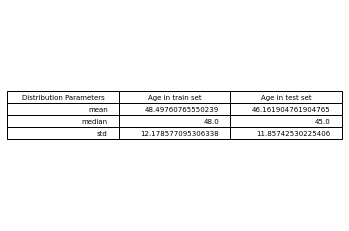

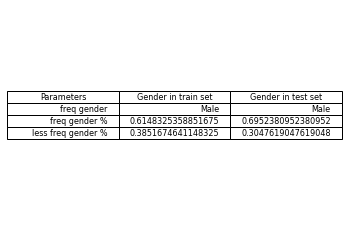

In [6]:
#Distribution in train and test set

fig1, ax1 =plt.subplots(1,1)
st1 = X_train.iloc[:,0].describe()
st2 = x_test.iloc[:,0].describe()
data = [['mean',st1['mean'],st2['mean']],['median',st1['50%'],st2['50%']],['std',st1['std'],st2['std']]]

column_labels=["Distribution Parameters", "Age in train set", "Age in test set"]
ax1.axis('tight')
ax1.axis('off')
ax1.table(cellText=data,colLabels=column_labels,loc="center")
plt.show()

fig2, ax2 =plt.subplots(1,1)
st1 = X_train.iloc[:,1].describe()
st2 = x_test.iloc[:,1].describe()
data = [['freq gender',st1['top'],st2['top']],['freq gender %',st1['freq']/st1['count'],st2['freq']/st2['count']],['less freq gender %',1-st1['freq']/st1['count'],1-st2['freq']/st2['count']]]
column_labels=["Parameters", "Gender in train set", "Gender in test set"]
ax2.axis('tight')
ax2.axis('off')
ax2.table(cellText=data,colLabels=column_labels,loc="center")
plt.show()

In [7]:
dict_stat_train={}
dict_stat_test={} 
for f in X_train.columns:
    if f == 'Age' or f == 'Gender':
        continue
    count = X_train[f].describe(exclude=[np.number])['count']
    top = X_train[f].describe(exclude=[np.number])['top']
    freq = X_train[f].describe(exclude=[np.number])['freq']
    if top == 'Yes':
        dict_stat_train['%  Yes in ' + str(f)]=freq/count
    else:
        dict_stat_train['%  Yes in ' + str(f)]=1-freq/count
    
    count = x_test[f].describe(exclude=[np.number])['count']
    top = x_test[f].describe(exclude=[np.number])['top']
    freq = x_test[f].describe(exclude=[np.number])['freq']
    if top == 'Yes':
        dict_stat_test['%  Yes in ' + str(f)]=freq/count
    else:
        dict_stat_test['%  Yes in ' + str(f)]=1-freq/count

print('Train set stats')
print(dict_stat_train)
print('Test set stats')
print(dict_stat_test)

Train set stats
{'%  Yes in Increased Urination': 0.5047846889952153, '%  Yes in Increased Thirst': 0.46172248803827753, '%  Yes in Sudden Weight Loss': 0.416267942583732, '%  Yes in Weakness': 0.5813397129186603, '%  Yes in Increased Hunger': 0.46650717703349287, '%  Yes in Genital Thrush': 0.20334928229665072, '%  Yes in Visual Blurring': 0.4593301435406698, '%  Yes in Itching': 0.49521531100478466, '%  Yes in Irritability': 0.24641148325358853, '%  Yes in Delayed Healing': 0.47846889952153115, '%  Yes in Partial Paresis': 0.43779904306220097, '%  Yes in Muscle Stiffness': 0.37559808612440193, '%  Yes in Hair Loss': 0.34928229665071775, '%  Yes in Obesity': 0.1722488038277512, '%  Yes in Family History': 0.4976076555023924}
Test set stats
{'%  Yes in Increased Urination': 0.4571428571428572, '%  Yes in Increased Thirst': 0.38095238095238093, '%  Yes in Sudden Weight Loss': 0.4095238095238095, '%  Yes in Weakness': 0.6, '%  Yes in Increased Hunger': 0.4095238095238095, '%  Yes in Geni

If training and test datasets are not sampled from the same distribution, there is an imbalance between them then training  cannot be used to predict anything about the test dataset in a usable manner.
<br>
This problem is known as **DataShift**
<br>
We can treat DataShift by:
<br>
1. Dropping of drifting features
2. Importance weight using Density Ratio Estimation

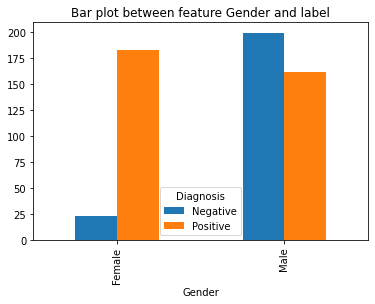

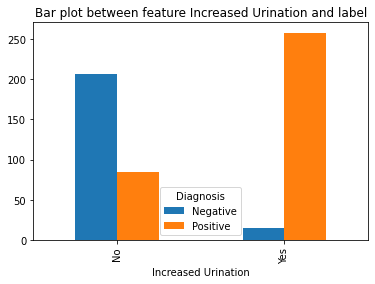

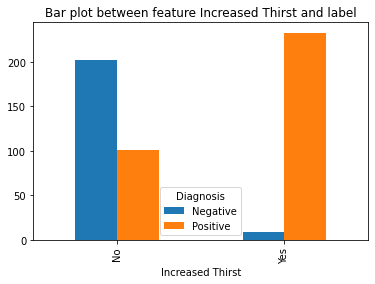

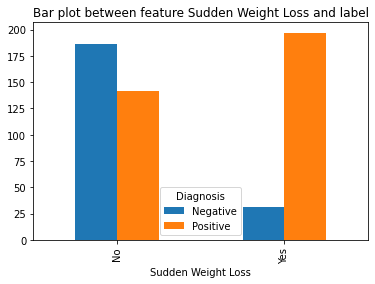

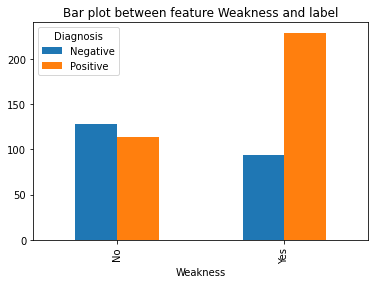

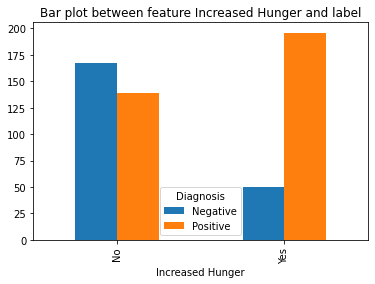

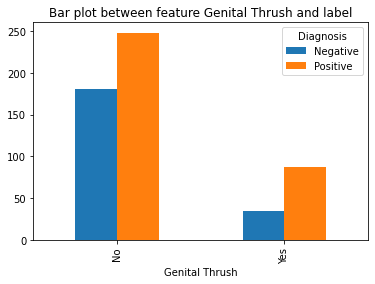

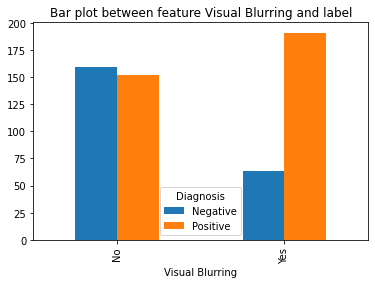

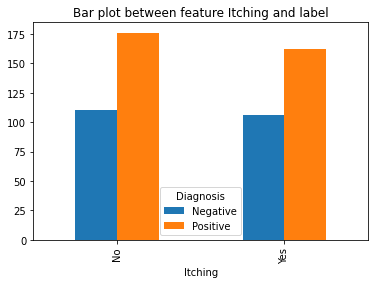

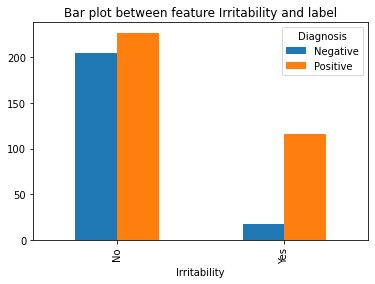

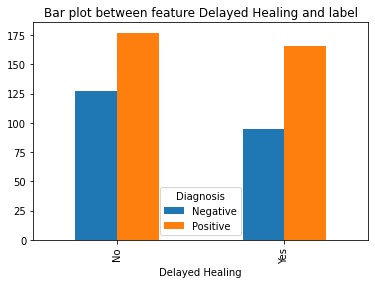

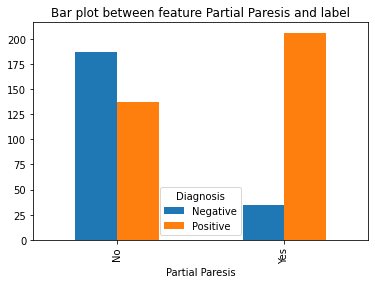

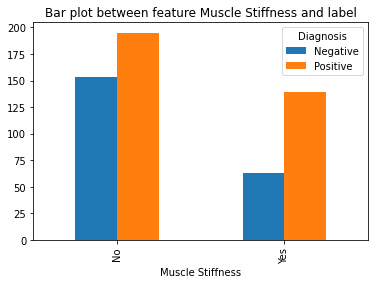

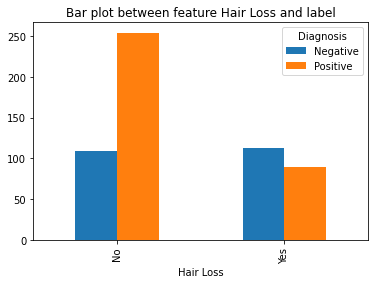

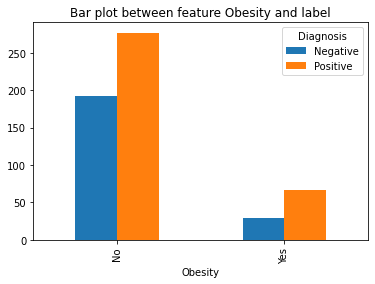

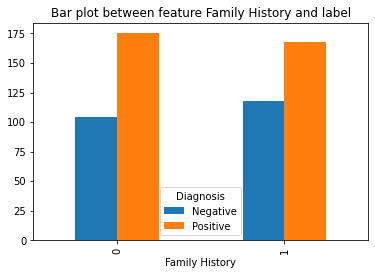

In [8]:
# relationship between feature and label
diagnosis_column = df_raw["Diagnosis"]
for f in df_raw.columns:
    if f == "Diagnosis" or f == "Age":
        continue
    series = df_raw.groupby([f,diagnosis_column]).size().unstack(level=1).plot(kind='bar')
    plt.show
    plt.title('Bar plot between feature ' + str(f) + ' and label')

Text(0, 0.5, 'Counts')

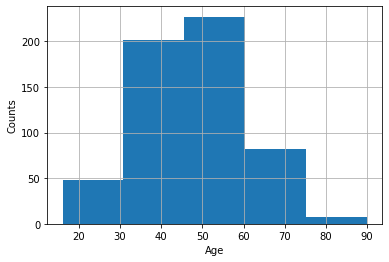

In [9]:
age_hist=df_raw["Age"].hist(bins=5)
age_hist.set_xlabel("Age")
age_hist.set_ylabel("Counts")

Feature label bar plot revealed that women are more likely to have T1D. This is unexpected becasue according to the following [paper](https://pubmed.ncbi.nlm.nih.gov/18205768/#:~:text=The%20mean%20annual%20incidence%20rate,male%2Ffemale%20ratio%20of%201.8/) males are more likley to have T1D.


We think the following features (Increase Urination, Increased thirst, Sudden weight loss, Increased hunger, Visual Blurring, Irritability, Partial Paresis) are more important becasue their bar plot indicate that a person which is positive to a feature is very likley to have T1D.

**Encoding data as one hot vector:**

In [10]:
for col in df:
    vector = pd.get_dummies(df[[col]].astype(str), drop_first=True) # convertion to string allows us to work with the ages
    df = pd.concat([df,vector],axis=1)
    df = df.drop(columns=[col])
df.head()

,Age_25,Age_26,Age_27,Age_28,Age_29,Age_30,Age_31,Age_32,Age_33,Age_34,...,Visual Blurring_Yes,Itching_Yes,Irritability_Yes,Delayed Healing_Yes,Partial Paresis_Yes,Muscle Stiffness_Yes,Hair Loss_Yes,Obesity_Yes,Diagnosis_Positive,Family History_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,1,0


**Machine Learning Models:**

In [11]:
y_1H = df["Diagnosis_Positive"]
X_1H = df.drop(['Diagnosis_Positive'],axis=1)

# splitting one hot vector data into train and test set
X_train, x_test, Y_train, y_test = train_test_split(X_1H, y_1H, test_size = 0.20, random_state = 10, stratify=y_1H)

# We define the functions for calculating our performances
calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

We Start with our linear model - the logistic regression: 

In [12]:
n_splits = 5
max_iter = 2000
solver = 'liblinear'

skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)

log_reg = LogisticRegression(random_state=5, max_iter=max_iter, solver=solver)
lmbda = np.array([0.001, 0.01, 1, 10, 100, 1000])
pipe = Pipeline(steps=[('logistic', log_reg)])
clf = GridSearchCV(estimator=pipe, param_grid={'logistic__C': 1/lmbda, 'logistic__penalty': ['l2']},
        scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
        refit='roc_auc', verbose=0, return_train_score=True)
clf.fit(X_train, Y_train)
log_reg_opt = clf.best_estimator_
y_pred_test = log_reg_opt.predict(x_test)
y_pred_proba_test = log_reg_opt.predict_proba(x_test)

Now we check the Logistic regression performance:

Sensitivity is 0.89
Specificity is 0.93
PPV is 0.95
NPV is 0.84
Accuracy is 0.90
F1 is 0.92
AUROC is 0.95
Loss is 3.29


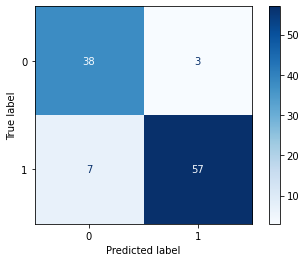

In [13]:
metrics (log_reg_opt,x_test,y_test,y_pred_test, y_pred_proba_test)

We continue with another linear model, this time - the linear SVM:

In [14]:
svc = SVC(probability=True)
C = np.array([0.001, 0.01, 1, 10, 100, 1000])
pipe = Pipeline(steps=[('svm', svc)])
svm_lin = GridSearchCV(estimator=pipe,
             param_grid={'svm__kernel':['linear'], 'svm__C':C},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
svm_lin.fit(X_train, Y_train)
best_svm_lin = svm_lin.best_estimator_
y_pred_test = best_svm_lin.predict(x_test)
y_pred_proba_test = best_svm_lin.predict_proba(x_test)

Now we check the linear SVM performance:

Sensitivity is 0.89
Specificity is 0.98
PPV is 0.98
NPV is 0.85
Accuracy is 0.92
F1 is 0.93
AUROC is 0.95
Loss is 2.63


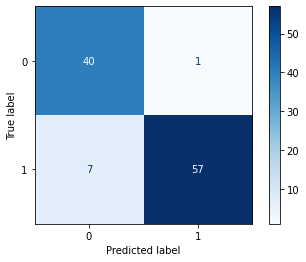

In [15]:
metrics (best_svm_lin,x_test,y_test,y_pred_test, y_pred_proba_test)

Now we want to train on a non-lionear model:

In [16]:
svc1 = SVC(degree=3, gamma='scale',probability=True)
C = np.array([0.001,0.1,1, 100, 1000])
param = [{'svm__C': C, 'svm__kernel': ['rbf','poly'], 'svm__gamma':['auto','scale']}]
pipe = Pipeline(steps=[('svm', svc1)])
# finding the best parameters
svm_nonlin = GridSearchCV(estimator=pipe, param_grid=param,scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
svm_nonlin.fit(X_train, Y_train)
svm_nonlin.best_params_

best_svm_nonlin = svm_nonlin.best_estimator_
y_pred_test = best_svm_nonlin.predict(x_test)
y_pred_proba_test = best_svm_nonlin.predict_proba(x_test)

Now we check the non-linear SVM performance:

Sensitivity is 0.91
Specificity is 1.00
PPV is 1.00
NPV is 0.87
Accuracy is 0.94
F1 is 0.95
AUROC is 0.98
Loss is 1.97


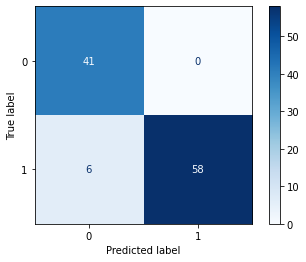

In [17]:
metrics (best_svm_nonlin,x_test,y_test,y_pred_test, y_pred_proba_test)

Q5: What performs best on this dataset? Linear or non-linear models?

We can see that using logistic regression produced the worst results in all aspects - Accuracy, F1, AUROC & loss. However, results were still good.
Using SVM (both linear & nonlinear) produced very good results. We notice there is no big differnce in most metricsbut in all of them we see a slight increase in the nonlinear model, for example the AUROC - where we in the linear model we get a value of 0.95 (which is great!) and for the nonlinear model we get a value of 0.98 (which is almost perfect). Due to this we will state that non-linear models performs slightly better on our dataset, even though the differnces are very slight. It is important to note - our dataset is not very big, and we get very good performance statstics, which might suggest that our model is a bit overfitted.

Sensitivity is 0.91
Specificity is 1.00
PPV is 1.00
NPV is 0.87
Accuracy is 0.94
F1 is 0.95
AUROC is 0.98
Loss is 1.97


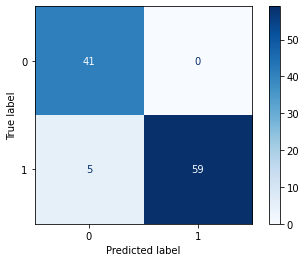

In [18]:
rfc = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,max_features='auto')
model=rfc.fit(X_train,Y_train)
y_pred_rfc = model.predict(x_test)

metrics (model,x_test,y_test,y_pred_test, y_pred_proba_test)

In [38]:
# finding 2 best features by RFC

m1=max(model.feature_importances_)
l=list(model.feature_importances_)
new_l=set(l)
new_l.remove(m1)
m2=max(new_l)

best_feature=np.where(model.feature_importances_==m1)
second_best_feature=(np.where(model.feature_importances_==m2))
best_feature=best_feature[0]
second_best_feature=second_best_feature[0]

l=X_1H.columns
name1=l[best_feature]
name2=l[second_best_feature]
print(name1,name2)

Index(['Increased Thirst_Yes'], dtype='object') Index(['Increased Urination_Yes'], dtype='object')


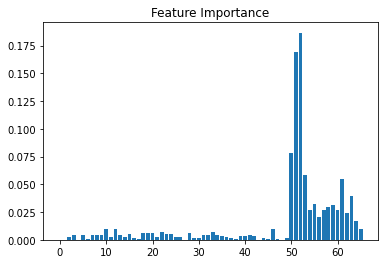

In [39]:
plt.figure()
plt.title('Feature Importance')
plt.bar(range(X_1H.shape[1]),model.feature_importances_)
plt.show()

Accroding to feature importance bar plot, we can see that features from index 50 in X_1H have higher significance:

In [40]:
print(l[50:-1])

Index(['Gender_Male', 'Increased Urination_Yes', 'Increased Thirst_Yes',
       'Sudden Weight Loss_Yes', 'Weakness_Yes', 'Increased Hunger_Yes',
       'Genital Thrush_Yes', 'Visual Blurring_Yes', 'Itching_Yes',
       'Irritability_Yes', 'Delayed Healing_Yes', 'Partial Paresis_Yes',
       'Muscle Stiffness_Yes', 'Hair Loss_Yes', 'Obesity_Yes'],
      dtype='object')


Q6,a: What are the 2 most improtant features according to the random forest?

Increased urination & Increased thrist.

Q6,b: Does this match up exactly with the feature exploration you did?


Yes! We can notice in the plots we disaplyed in Q3 that for both our most important features - almost all positive patients experience these symptoms. This is also known to us from the literature ([credit](https://www.mayoclinic.org/diseases-conditions/type-1-diabetes/symptoms-causes/syc-20353011)) - patients with T1D experience in very high concentration of glucose in their systems - making their bodies try to balance this concentration by either thrist or urination.

**Data Separabillity Visualization**

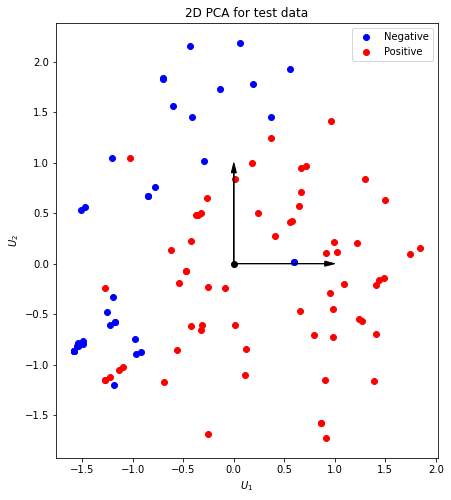

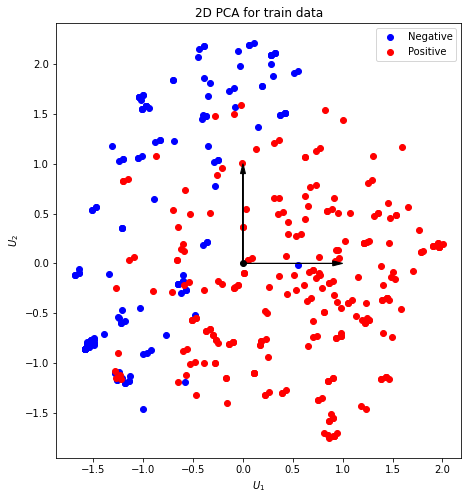

In [37]:
pca = PCA(n_components=2, whiten=True)
X_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(x_test)
plt_2d_pca(x_test_pca,y_test, '2D PCA for test data')
plt_2d_pca(X_train_pca,Y_train, '2D PCA for train data')

By looking at the plot, we can see that other than some outliers (which will always be in the data), the data looks seperable (2nd or 3rd degree polynomial should do the job very well).

We will start by training on our dimensionality reduced training set:

Logistic regression:

Sensitivity is 0.73
Specificity is 0.95
PPV is 0.96
NPV is 0.70
Accuracy is 0.82
F1 is 0.83
AUROC is 0.92
Loss is 6.25


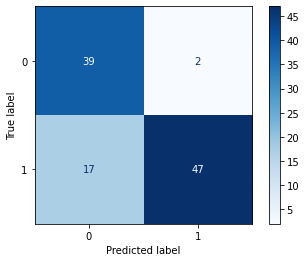

In [22]:
skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)

log_reg = LogisticRegression(random_state=5, max_iter=max_iter, solver=solver)
lmbda = np.array([0.001, 0.01, 1, 10, 100, 1000])
pipe = Pipeline(steps=[('logistic', log_reg)])
clf = GridSearchCV(estimator=pipe, param_grid={'logistic__C': 1/lmbda, 'logistic__penalty': ['l2']},
        scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
        refit='roc_auc', verbose=0, return_train_score=True)
clf.fit(X_train_pca, Y_train)
log_reg_opt_pca = clf.best_estimator_
y_pred_test = log_reg_opt_pca.predict(x_test_pca)
y_pred_proba_test = log_reg_opt_pca.predict_proba(x_test_pca)
metrics (log_reg_opt_pca,x_test_pca,y_test,y_pred_test, y_pred_proba_test)

Linear SVM:

Sensitivity is 0.75
Specificity is 0.93
PPV is 0.94
NPV is 0.70
Accuracy is 0.82
F1 is 0.83
AUROC is 0.92
Loss is 6.25


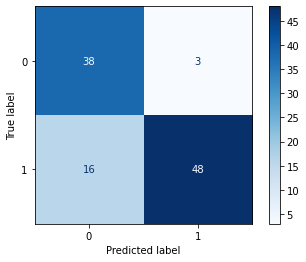

In [23]:
svc = SVC(probability=True)
C = np.array([0.001, 0.01, 1, 10, 100, 1000])
pipe = Pipeline(steps=[('svm', svc)])
svm_lin = GridSearchCV(estimator=pipe,
             param_grid={'svm__kernel':['linear'], 'svm__C':C},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
svm_lin.fit(X_train_pca, Y_train)
best_svm_lin_pca = svm_lin.best_estimator_
y_pred_test = best_svm_lin_pca.predict(x_test_pca)
y_pred_proba_test = best_svm_lin_pca.predict_proba(x_test_pca)
metrics (best_svm_lin_pca,x_test_pca,y_test,y_pred_test, y_pred_proba_test)

Non-linear SVM:

Sensitivity is 0.89
Specificity is 0.76
PPV is 0.85
NPV is 0.82
Accuracy is 0.84
F1 is 0.87
AUROC is 0.94
Loss is 5.59


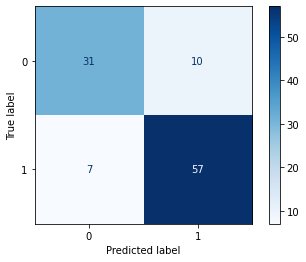

In [24]:
svc1 = SVC(degree=3, gamma='scale',probability=True)
C = np.array([0.001,0.1,1, 100, 1000])
param = [{'svm__C': C, 'svm__kernel': ['rbf','poly'], 'svm__gamma':['auto','scale']}]
pipe = Pipeline(steps=[('svm', svc1)])
# finding the best parameters
svm_nonlin = GridSearchCV(estimator=pipe, param_grid=param,scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
svm_nonlin.fit(X_train_pca, Y_train)
svm_nonlin.best_params_

best_svm_nonlin_pca = svm_nonlin.best_estimator_
y_pred_test = best_svm_nonlin_pca.predict(x_test_pca)
y_pred_proba_test = best_svm_nonlin_pca.predict_proba(x_test_pca)
metrics (best_svm_nonlin_pca,x_test_pca,y_test,y_pred_test, y_pred_proba_test)

Now we will reduce the data to the 2 best features we found in section 6 and repeat the process:

In [26]:
X_train_2f = X_train.iloc[:,[51,52]]
x_test_2f = x_test.iloc[:,[51,52]]

Logistic Regression:

Sensitivity is 0.78
Specificity is 0.88
PPV is 0.91
NPV is 0.72
Accuracy is 0.82
F1 is 0.84
AUROC is 0.86
Loss is 6.25


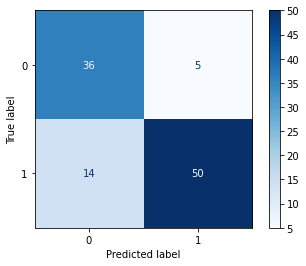

In [27]:
skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)

log_reg = LogisticRegression(random_state=5, max_iter=max_iter, solver=solver)
lmbda = np.array([0.001, 0.01, 1, 10, 100, 1000])
pipe = Pipeline(steps=[('logistic', log_reg)])
clf = GridSearchCV(estimator=pipe, param_grid={'logistic__C': 1/lmbda, 'logistic__penalty': ['l2']},
        scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
        refit='roc_auc', verbose=0, return_train_score=True)
clf.fit(X_train_2f, Y_train)
log_reg_opt_2f = clf.best_estimator_
y_pred_test = log_reg_opt_2f.predict(x_test_2f)
y_pred_proba_test = log_reg_opt_2f.predict_proba(x_test_2f)
metrics (log_reg_opt_2f,x_test_2f,y_test,y_pred_test, y_pred_proba_test)

Linear SVM:

Sensitivity is 0.78
Specificity is 0.88
PPV is 0.91
NPV is 0.72
Accuracy is 0.82
F1 is 0.84
AUROC is 0.86
Loss is 6.25


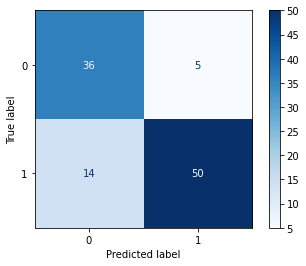

In [28]:
svc = SVC(probability=True)
C = np.array([0.001, 0.01, 1, 10, 100, 1000])
pipe = Pipeline(steps=[('svm', svc)])
svm_lin = GridSearchCV(estimator=pipe,
             param_grid={'svm__kernel':['linear'], 'svm__C':C},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
svm_lin.fit(X_train_2f, Y_train)
best_svm_lin_2f = svm_lin.best_estimator_
y_pred_test = best_svm_lin_2f.predict(x_test_2f)
y_pred_proba_test = best_svm_lin_2f.predict_proba(x_test_2f)
metrics (best_svm_lin_2f,x_test_2f,y_test,y_pred_test, y_pred_proba_test)

Non-Linear SVM:

Sensitivity is 0.78
Specificity is 0.88
PPV is 0.91
NPV is 0.72
Accuracy is 0.82
F1 is 0.84
AUROC is 0.86
Loss is 6.25


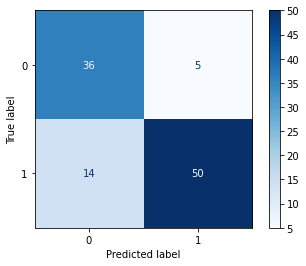

In [30]:
svc1 = SVC(degree=3, gamma='scale',probability=True)
C = np.array([0.001,0.1,1, 100, 1000])
param = [{'svm__C': C, 'svm__kernel': ['rbf','poly'], 'svm__gamma':['auto','scale']}]
pipe = Pipeline(steps=[('svm', svc1)])
# finding the best parameters
svm_nonlin = GridSearchCV(estimator=pipe, param_grid=param,scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf, refit='roc_auc', verbose=0, return_train_score=True)
svm_nonlin.fit(X_train_2f, Y_train)
svm_nonlin.best_params_
best_svm_nonlin_2f = svm_nonlin.best_estimator_
y_pred_test = best_svm_nonlin_2f.predict(x_test_2f)
y_pred_proba_test = best_svm_nonlin_2f.predict_proba(x_test_2f)
metrics (best_svm_nonlin_2f,x_test_2f,y_test,y_pred_test, y_pred_proba_test)

Q7: What performs better? 2 features or reduced dimensionality?

In order to answer this question, we summarized the most important metrics in the table above:

| | Accuracy| F1 | AUROC | Loss |
| --- | --- | --- | --- | --- |
| Log Regression PCA | 0.82 | 0.83 | 0.92 | 6.25 |
| Linear SVM PCA | 0.82 | 0.83 | 0.92 | 6.25 |
| Non-linear SVM PCA | 0.84 | 0.87 | 0.94 | 5.59 |
| Log Regression 2Features | 0.82 | 0.84 | 0.86 | 6.25 |
| Linear SVM 2Features | 0.82 | 0.84 | 0.86 | 6.25 |
| Non-linear SVM 2Features | 0.82 | 0.84 | 0.86 | 6.25 |

First of all, we can notice that for the 2features data, all models perform exactly the same. This is expected because we have 2 good features whereas others are not good predictors, making even the simplest model very effective. When comparing between the different models for PCA, we can see that non-linear SVM improved all the evaluation metrics when compared to the linear models. When comparing between the 2 training sets, we can see that in general the PCA set shows better metrics, especially for AUROC. When using a non-linear model with the PCA data we see the highest increase in all of the metrics. We will conclude that the PCA data performs better.